# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at a used car dealership in the UK. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

In [74]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import tree

## Import Data

In [2]:
#First we need to import the data and show the first 5 rows to get sense of it
df = pd.read_csv("data/toyota.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [3]:
#Checking the size of data
print("Our data has {0} rows and {1} columns".format(df.shape[0],df.shape[1]))

Our data has 6738 rows and 9 columns


In [4]:
#Now Let`s check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [70]:
np.sum(df.isnull())

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

##### Looks there is No null Values, so we don't need to handle them

## Data Pre-processing

In [5]:
#As We see Year and enginSize are numeric values. Though, we need to format them as Categorical data because they are not continous
df.year = df.year.astype("category")
df.engineSize = df.engineSize.astype("category")

##### Let's check duplicates

In [6]:
df.duplicated().sum()

39

In [7]:
#We've 39 duplicate rows from 6738 rows, we can drop them
cleandf = df.drop_duplicates()
cleandf.reset_index(drop=True, inplace=True)

### Check Numerical features:

##### let`s get numerical volumns in a list

In [8]:
numericalcol = df._get_numeric_data().columns.tolist()

##### We Will get data statistics from describe

In [9]:
cleandf.describe()

,price,mileage,tax,mpg
count,6699.000000,6699.000000,6699.000000,6699.000000
mean,12529.799074,22889.588745,94.549933,63.078728
std,6358.562625,19109.288501,73.942649,15.861037
min,850.000000,2.000000,0.000000,2.800000
25%,8266.500000,9488.500000,0.000000,55.400000
50%,10798.000000,18571.000000,135.000000,62.800000
75%,14995.000000,31059.500000,145.000000,70.600000
max,59995.000000,174419.000000,565.000000,235.000000


### Plotting histogram for Numerical Data:

##### We'll plot the histogram for different features to better understanding of out data distribution

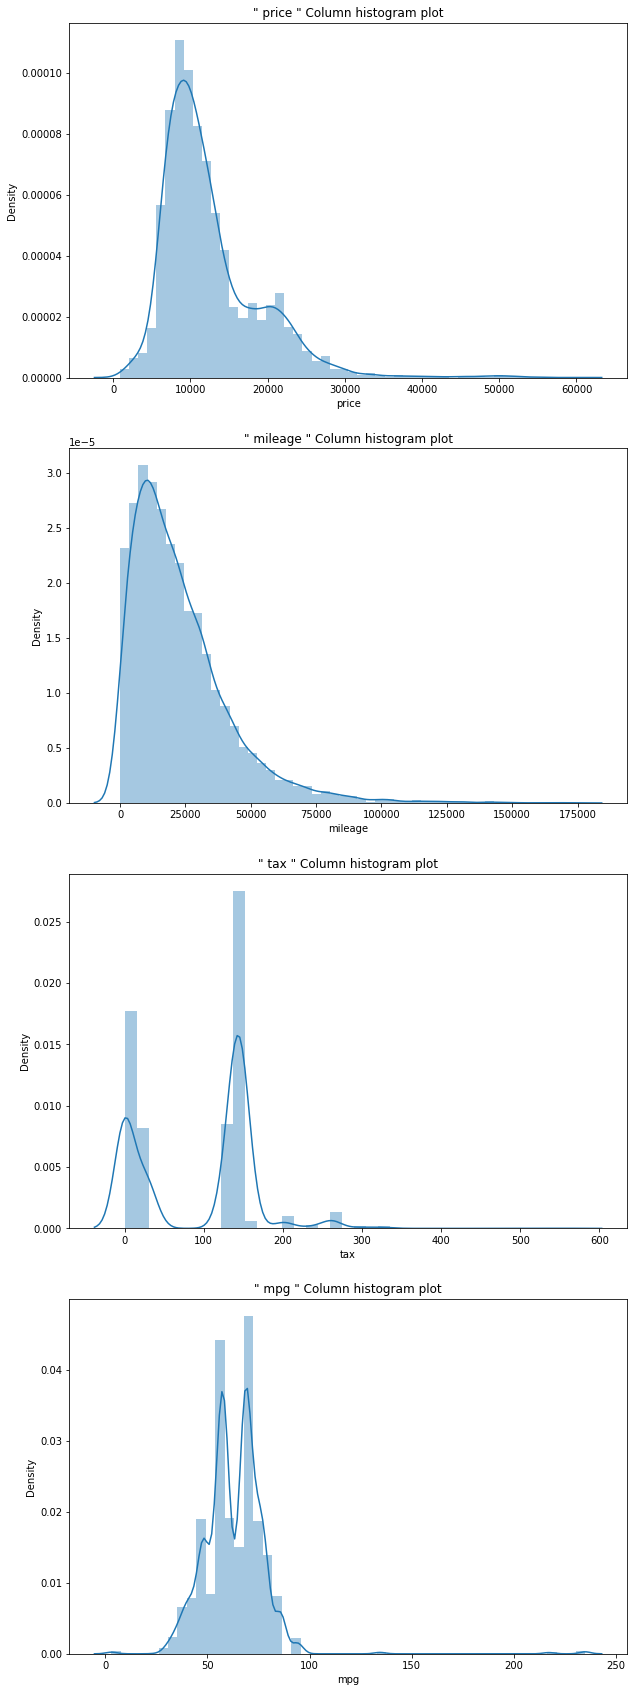

In [10]:
fig, axes = plt.subplots(4,1, figsize=(10,30))
for i in range(len(numericalcol)):
    plt.subplot(int(f"41{i+1}"))
    sns.distplot(cleandf[numericalcol[i]])
    plt.title('" {} " Column histogram plot'.format(numericalcol[i]))
plt.show();

#### We can see that :
- Taxes are not well-distributed, we can fix this by using the tax percentage instead of the tax values.

- Price and Mileage are right-skewed, we can fix this by using the square root of the feature.

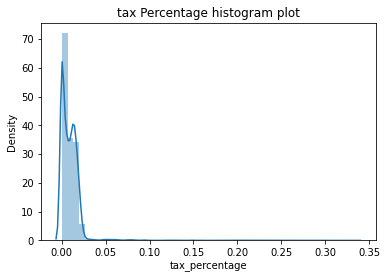

In [11]:
#Let's handle the taxes
cleandf["tax_percentage"] = cleandf["tax"]/cleandf["price"]
sns.distplot(cleandf["tax_percentage"])
plt.title('tax Percentage histogram plot')
plt.show();

#### tax_percentage right skewed too, so we can scale it to the squared root along with Price and Mileage

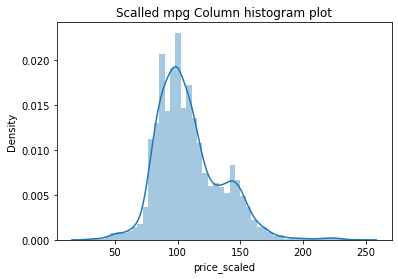

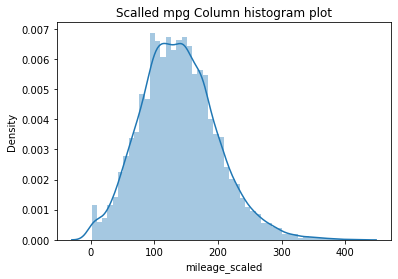

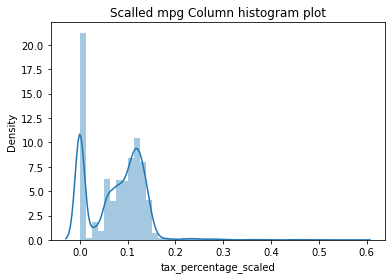

In [12]:
scale_columns = ["price", "mileage", "tax_percentage"]
for col in scale_columns:
    cleandf[f"{col}_scaled"] = cleandf[[col]]**0.5
    sns.distplot(cleandf[f"{col}_scaled"])
    plt.title('Scalled {} Column histogram plot'.format(numericalcol[i]))
    plt.show();

##### We can see that scaling improved the price and mileage columns but didn't improve the tax_percentage much . Though, this is still better than the previous distribution.

### Check categorigal features

##### let`s get categorical columns in a list

In [13]:
categorical = cleandf.select_dtypes(include=['object','category']).columns.tolist()
categorical

['model', 'year', 'transmission', 'fuelType', 'engineSize']

##### Let`s check if they are well-formatted

In [14]:
for col in categorical :
    print(' " {} " Column'.format(col))
    print(cleandf[col].unique())
    print('------------------------')

 " model " Column
[' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser']
------------------------
 " year " Column
[2016, 2017, 2015, 2020, 2013, ..., 2009, 2002, 1999, 2000, 1998]
Length: 23
Categories (23, int64): [2016, 2017, 2015, 2020, ..., 2002, 1999, 2000, 1998]
------------------------
 " transmission " Column
['Manual' 'Automatic' 'Semi-Auto' 'Other']
------------------------
 " fuelType " Column
['Petrol' 'Other' 'Hybrid' 'Diesel']
------------------------
 " engineSize " Column
[2.0, 1.8, 1.2, 1.6, 1.4, ..., 2.4, 3.0, 2.8, 4.2, 4.5]
Length: 16
Categories (16, float64): [2.0, 1.8, 1.2, 1.6, ..., 3.0, 2.8, 4.2, 4.5]
------------------------


In [15]:
# as we see we have spaces in model column, let's delete them
cleandf.model = cleandf.model.str.strip()
cleandf.model.unique()

array(['GT86', 'Corolla', 'RAV4', 'Yaris', 'Auris', 'Aygo', 'C-HR',
       'Prius', 'Avensis', 'Verso', 'Hilux', 'PROACE VERSO',
       'Land Cruiser', 'Supra', 'Camry', 'Verso-S', 'IQ', 'Urban Cruiser'],
      dtype=object)

##### Let's check the data distribution for each category

In [16]:
#cleandf.model.value_counts(ascending=False)

In [17]:
for col in categorical :
    print(' " {} " Column'.format(col))
    print(cleandf[col].value_counts(ascending=False))
    print('------------------------')

 " model " Column
Yaris            2117
Aygo             1940
Auris             709
C-HR              479
RAV4              467
Corolla           265
Prius             232
Avensis           114
Verso             114
Hilux              85
GT86               73
Land Cruiser       51
PROACE VERSO       15
Supra              12
Camry              11
IQ                  8
Urban Cruiser       4
Verso-S             3
Name: model, dtype: int64
------------------------
 " year " Column
2017    2015
2019    1265
2018    1014
2016     990
2015     522
2014     351
2013     203
2020     127
2012      42
2011      40
2009      29
2007      20
2008      19
2010      18
2005      12
2006      11
2004       7
2003       6
2002       4
1999       1
2001       1
2000       1
1998       1
Name: year, dtype: int64
------------------------
 " transmission " Column
Manual       3793
Automatic    2651
Semi-Auto     254
Other           1
Name: transmission, dtype: int64
------------------------
 " fuelType " 

##### As we see we have one value for Other in the transmission column. So It's better to remove it as our model won't learn from it.
we also have some engineSize == 0 wich doesn't make sense, So we will clean them

In [18]:
cleandf = cleandf[cleandf.transmission != "Other"]
cleandf.reset_index(inplace=True, drop=True)

In [32]:
cleandf = cleandf[cleandf.engineSize != 0 ]
cleandf.reset_index(inplace=True, drop=True)

In [34]:
#check to see if it`s cleaned 
cleandf[cleandf["engineSize"]==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,tax_percentage,price_scaled,mileage_scaled,tax_percentage_scaled


### Plotting the countplot for categorical data:

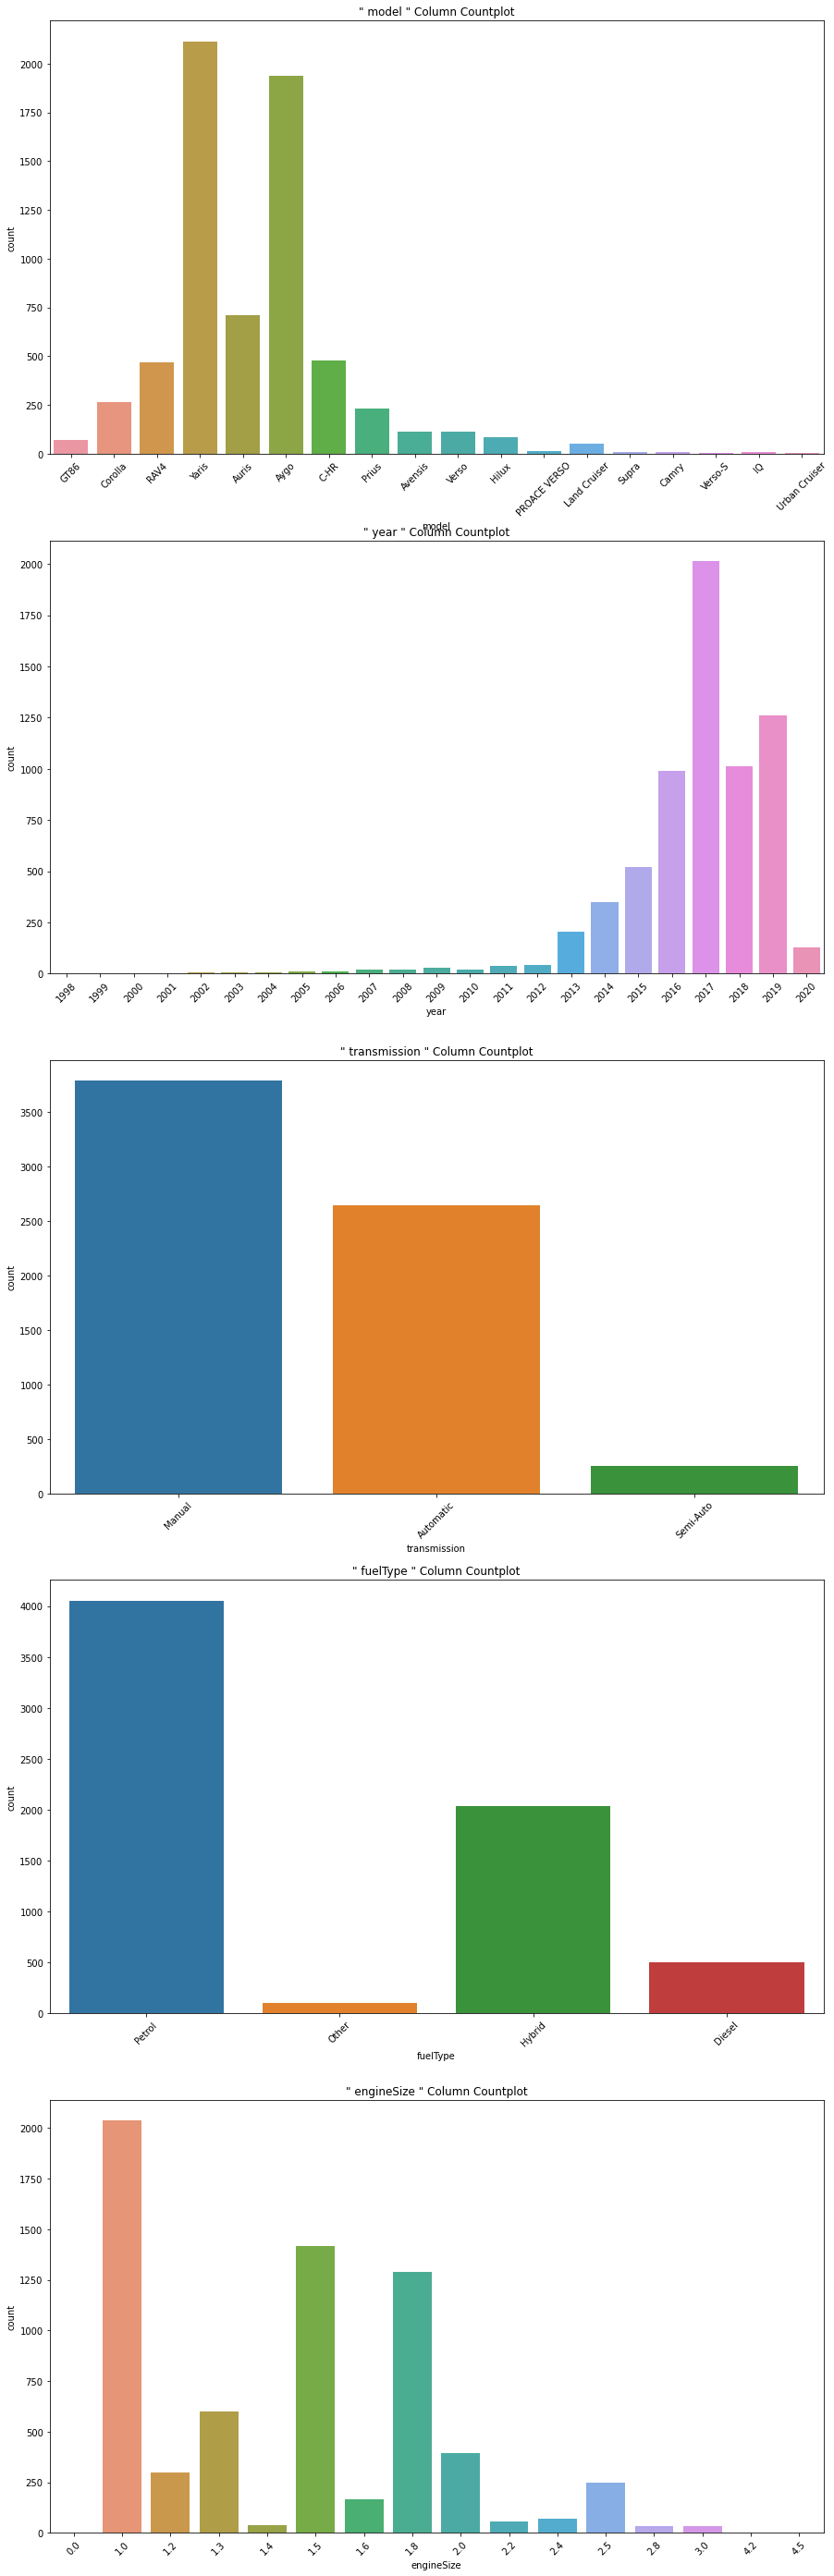

In [35]:
fig, axes = plt.subplots(5,1, figsize=(15,50))
for i in range(len(categorical)):
    plt.subplot(int(f"51{i+1}"))
    sns.countplot(data=cleandf,
                  x=categorical[i])
    plt.xticks(rotation=45)
    plt.title('" {} " Column Countplot'.format(categorical[i]))
plt.show();

#### Now Let's Understand the relationship between variables:

##### Let's check the heat map to understand the correlation coeefecient between different variable

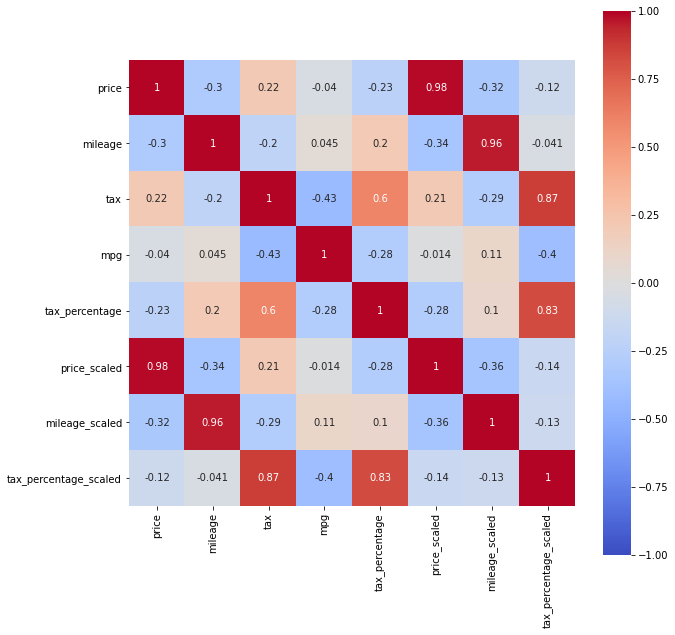

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(cleandf.corr("pearson"),vmin=-1,vmax=1,cmap='coolwarm',annot=True,square=True);
plt.show();

This is the list of sorted correlation of variables to the target

In [58]:
df1Corr=pd.DataFrame(cleandf.corr().unstack().sort_values(ascending=False)['price'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the target
price,1.000000
price_scaled,0.984510
tax,0.215653
mpg,-0.039723
tax_percentage_scaled,-0.123056
tax_percentage,-0.231815
mileage,-0.301018
mileage_scaled,-0.324676


##### We can see that:

- Correlation between price and tax_percentage is better than the scaled value, so we won't use scaling with taxes_percentage
- Price is inversly proportional with age (Highest Correlation)
- Price is inversly proportional with mileage and tax_percentage

In [37]:
cleandf.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'tax_percentage', 'price_scaled', 'mileage_scaled',
       'tax_percentage_scaled'],
      dtype='object')

## Model Building

#### First We'll encode categorical variable:

In [38]:
modeldf = cleandf.merge(pd.get_dummies(cleandf[categorical]), left_index=True, right_index=True, how="left")
modeldf.drop(columns=categorical, inplace=True)
modeldf.drop(columns=['price', 'mileage', 'tax', 'tax_percentage_scaled'], inplace=True)
modeldf.reset_index(inplace=True, drop=True)

In [39]:
modeldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6692 entries, 0 to 6691
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mpg                     6692 non-null   float64
 1   tax_percentage          6692 non-null   float64
 2   price_scaled            6692 non-null   float64
 3   mileage_scaled          6692 non-null   float64
 4   model_Auris             6692 non-null   uint8  
 5   model_Avensis           6692 non-null   uint8  
 6   model_Aygo              6692 non-null   uint8  
 7   model_C-HR              6692 non-null   uint8  
 8   model_Camry             6692 non-null   uint8  
 9   model_Corolla           6692 non-null   uint8  
 10  model_GT86              6692 non-null   uint8  
 11  model_Hilux             6692 non-null   uint8  
 12  model_IQ                6692 non-null   uint8  
 13  model_Land Cruiser      6692 non-null   uint8  
 14  model_PROACE VERSO      6692 non-null   

### First Model Let`s try Linear regression

In [159]:
#Let`s Define out Features X and Our Label y
y = modeldf['price_scaled']
X = modeldf.drop(columns="price_scaled")
#Let's split our dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)      

#Let's build the linear regression model
model =LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(' Linear Regression Model Score on Test Data is {}'.format(model.score(X_test, y_test)))

 Linear Regression Model Score on Test Data is 0.9623845640290084


##### We are interested in the price estimates where we go £1500 above the actual market price becasue these cars won't be sold.

In [160]:
#We'll square prices as we are using the sqrt price in the model:
predicted_prices = y_pred**2
actual_prices = y_test**2

difference = predicted_prices - actual_prices

In [161]:
#Check number of cars where our model exceeded the £1500 threshold
(difference >= 1500).sum()

105

In [162]:
#Check ratio of cars where our model exceeded the £1500 threshold
(difference >= 1500).sum()/len(difference)

0.07841672890216579

In [163]:
RMSE_1 = np.sqrt((difference**2).mean()).round(0)
print(f"RMSE is £{RMSE_1}")

RMSE is £1267.0


In [164]:
from sklearn.metrics import mean_squared_error 

def model_predictions(x, X_train, X_test, y_train, y_test):
    if x == "linear":
        model = LinearRegression()
        model.fit(X_train, y_train)
        print("linear:")
        predictions = model.predict(X_test)
    elif x=="ridge":
        model = linear_model.Ridge()
        model.fit(X_train, y_train)
        print("Decision Tree:")
        predictions = model.predict(X_test)
    elif x=="knn":
        n_neighbors=5
        model = neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
        model.fit(X_train, y_train)
        print ("knn:")
        predictions = model.predict(X_test)
    elif x=="baysian":
        model = linear_model.BayesianRidge()
        model.fit(X_train, y_train)
        print ("baysian:")
        predictions = model.predict(X_test)
    elif x=="DecisionTree":
        model = tree.DecisionTreeRegressor(max_depth=1)
        model.fit(X_train, y_train)
        print ("DecisionTree:")
        predictions = model.predict(X_test)    
    elif x=="svr":
        model = svm.SVR()
        model.fit(X_train, y_train)
        print ("svr:")
        predictions = model.predict(X_test)

    else:
        print ("Input should be logistic, linear, ridge, knn, baysian, DecisionTree,or svr")   
    
    #We'll square prices as we are using the sqrt price in the model:
    predicted_prices = predictions**2
    actual_prices = y_test**2
    difference = predicted_prices - actual_prices
    
    #Check number of cars where our model exceeded the £1500 threshold
    diff = (difference >= 1500).sum()
    print('Model Score is {}'.format(model.score(X_test, y_test)))
    
    print("RMSE of the model on test set is: £",  np.sqrt(((difference)**2).mean()).round(0))
    
    print('cars exceeded £1500 is {}'.format(diff))
    #Check ratio of cars where our model exceeded the £1500 threshold
    print('cars exceeded ratio is {} %'.format(diff/len(difference)))
    return [model, predictions,diff]

In [165]:
testlist = {}
testlist = dict()
model_list = ['linear', 'ridge', 'knn', 'baysian', 'DecisionTree','svr']
for model in model_list:
    model1, predictions,diff = model_predictions(model, X_train, X_test, y_train, y_test)
    testlist[model] = diff
    print('----------------------\n')

linear:
Model Score is 0.9623845640290084
RMSE of the model on test set is: £ 1267.0
cars exceeded £1500 is 105
cars exceeded ratio is 0.07841672890216579 %
----------------------

Decision Tree:
Model Score is 0.9607879805845368
RMSE of the model on test set is: £ 1288.0
cars exceeded £1500 is 108
cars exceeded ratio is 0.08065720687079911 %
----------------------

knn:
Model Score is 0.7740363792961972
RMSE of the model on test set is: £ 3309.0
cars exceeded £1500 is 209
cars exceeded ratio is 0.15608663181478716 %
----------------------

baysian:
Model Score is 0.9622748622307233
RMSE of the model on test set is: £ 1269.0
cars exceeded £1500 is 105
cars exceeded ratio is 0.07841672890216579 %
----------------------

DecisionTree:
Model Score is 0.29896905963101117
RMSE of the model on test set is: £ 5670.0
cars exceeded £1500 is 490
cars exceeded ratio is 0.3659447348767737 %
----------------------

svr:
Model Score is 0.08968837979467426
RMSE of the model on test set is: £ 6481.0
c

In [167]:
# check number of cars that will not be sold in each model
testlist

{'linear': 105,
 'ridge': 108,
 'knn': 209,
 'baysian': 105,
 'DecisionTree': 490,
 'svr': 471}

## Final Otcomes:

- EDA was help use to understand the features, their distributions and their relationships
- Cleaning data was necessary in some columns such as engineSize which had some invalid values
- We built a simple linear regression which had RSME of £1402 , 95.66% R2 Score and 8.11% estimates over the market price + 1500
- Finally we used the Decision Tree Regressor which resulted in better results with RMSE is £922, higher R2 Score of 97.63% and and lowered our over-estimated prices to 4.62%
- Initial results of the decision tree model are satisfactory

## Future Work:

- Hyperparameter tuning needs to be done through Grid Search for example.
- other scaling methods if they can improve the data distribution.
- other encoding methods if they can improve the model performance and decrease this large number of columns
- large numbers of columns needs to be decreased through PCA .
- Other models needs to be tested such as XGBoost which would improve the results of the Decision Tree through ensemble learning where we make use of multiple weak learners.
- These actions should improve the pricing model and lower the number of cars with over price of 1500+